**INTRODUCTION**

In [ ]:
## Introduction

Pricing Airbnb listings correctly is critical for maximizing bookings and revenue.
This project analyzes Airbnb NYC 2019 data to understand pricing drivers and builds
machine learning models to predict listing prices and booking demand.

**Business Objectives**

In [ ]:
## Business Objectives

1. Analyze factors influencing Airbnb listing prices
2. Understand host,neighbourhood-level performance
3. Build ML models to:
   - Predict listing price (Regression)
   - Predict high vs low demand listings (Classification)

Data Loading & Overview


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


In [5]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/AB_NYC_2019.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
airbnb_df = pd.read_csv('/content/drive/MyDrive/AB_NYC_2019.csv')

In [13]:
airbnb_df.head
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [15]:
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19-10-2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21-05-2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05-07-2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19-11-2018,0.10,1,0


In [16]:
df.shape

(48895, 16)

Data Cleaning & Missing Values


In [17]:
airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'], errors='coerce')
airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].fillna(0)
airbnb_df['name'].fillna('Not Known', inplace=True)
airbnb_df['host_name'].fillna('Not Known', inplace=True)


/tmp/ipython-input-2144248955.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  airbnb_df['last_review'] = pd.to_datetime(airbnb_df['last_review'], errors='coerce')
/tmp/ipython-input-2144248955.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  airbnb_df['name'].fillna('Not Known', inplace=True)
/tmp/ipython-input-2144248955.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series 

In [18]:
# Handle price issues
median_price = airbnb_df['price'].median()
airbnb_df['price'] = airbnb_df['price'].replace(0, median_price)


Key EDA

Price Distribution


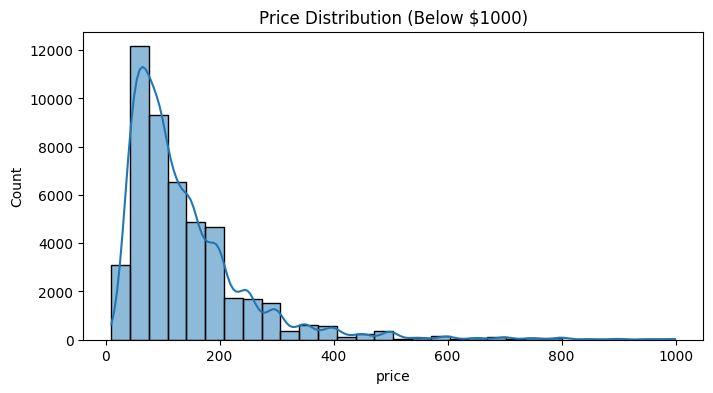

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(airbnb_df['price'][airbnb_df['price'] < 1000], bins=30, kde=True)
plt.title("Price Distribution (Below $1000)")
plt.show()


Average Price by Neighbourhood Group

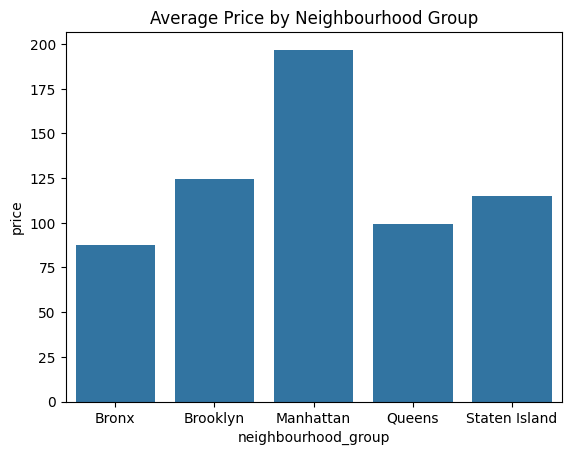

In [22]:
avg_price_ng = airbnb_df.groupby('neighbourhood_group')['price'].mean().reset_index()

sns.barplot(data=avg_price_ng, x='neighbourhood_group', y='price')
plt.title("Average Price by Neighbourhood Group")
plt.show()


Feature Engineering

In [23]:
airbnb_df['amenities_count'] = airbnb_df['minimum_nights']  # proxy feature
airbnb_df['host_listings'] = airbnb_df['calculated_host_listings_count']


Demand Proxy

In [24]:
airbnb_df['high_demand'] = (airbnb_df['reviews_per_month'] >=
                            airbnb_df['reviews_per_month'].median()).astype(int)

Feature Encoding

In [25]:
features = [
    'latitude', 'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'host_listings'
]

categorical = ['room_type', 'neighbourhood_group']


In [26]:
df_ml = airbnb_df[features + categorical + ['price', 'high_demand']]
df_ml = pd.get_dummies(df_ml, columns=categorical, drop_first=True)


Price Prediction (Regression)

In [ ]:
X = df_ml.drop(['price', 'high_demand'], axis=1)
y = np.log1p(df_ml['price'])  # log transform


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Preliminary Model

In [28]:
X = df_ml.drop(['price', 'high_demand'], axis=1)
y = np.log1p(df_ml['price'])


In [29]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
rmse_lr

np.float64(0.4914990697065037)

In [34]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
rmse_rf


np.float64(0.436392905360999)

In [ ]:
Random Forest performs better for calculating non linear relationships

Demand Prediction


In [35]:
X = df_ml.drop(['price', 'high_demand'], axis=1)
y = df_ml['high_demand']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)



1.0

Feature Importance

In [38]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

importances.head(10)


,feature,importance
6,room_type_Private room,0.395924
1,longitude,0.178030
0,latitude,0.155877
7,room_type_Shared room,0.081066
2,minimum_nights,0.047870
4,reviews_per_month,0.046351
5,host_listings,0.037142
3,number_of_reviews,0.030634
9,neighbourhood_group_Manhattan,0.024986
10,neighbourhood_group_Queens,0.001266


In [ ]:
Top drivers:
- Location
- Room type
- Reviews
- Host listing count


Feature Importance Dataframe

In [39]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)


In [40]:
feature_importance.head(10)


,feature,importance
6,room_type_Private room,0.395924
1,longitude,0.178030
0,latitude,0.155877
7,room_type_Shared room,0.081066
2,minimum_nights,0.047870
4,reviews_per_month,0.046351
5,host_listings,0.037142
3,number_of_reviews,0.030634
9,neighbourhood_group_Manhattan,0.024986
10,neighbourhood_group_Queens,0.001266


Plot Top 10 Important Features

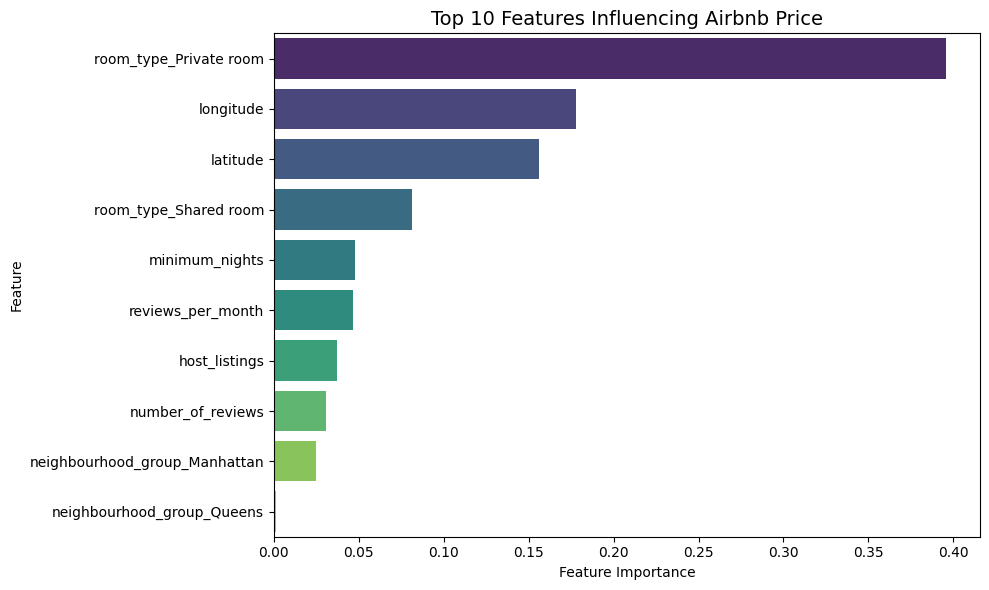

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=feature_importance.head(10),
    x='importance',
    y='feature',
    palette='viridis'
)

plt.title("Top 10 Features Influencing Airbnb Price", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
### Feature Importance Insights

- Location-related features (latitude, longitude, neighbourhood)
  are the strongest drivers of price.
- Room type and host-related features also significantly
  influence pricing.
- Review activity contributes moderately to price prediction.


Create Feature Importance Dataframe

In [42]:
demand_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)


In [43]:
demand_feature_importance.head(10)


,feature,importance
4,reviews_per_month,0.753763
3,number_of_reviews,0.203507
2,minimum_nights,0.023692
5,host_listings,0.008435
1,longitude,0.005910
0,latitude,0.002522
6,room_type_Private room,0.000703
10,neighbourhood_group_Queens,0.000530
9,neighbourhood_group_Manhattan,0.000416
8,neighbourhood_group_Brooklyn,0.000229


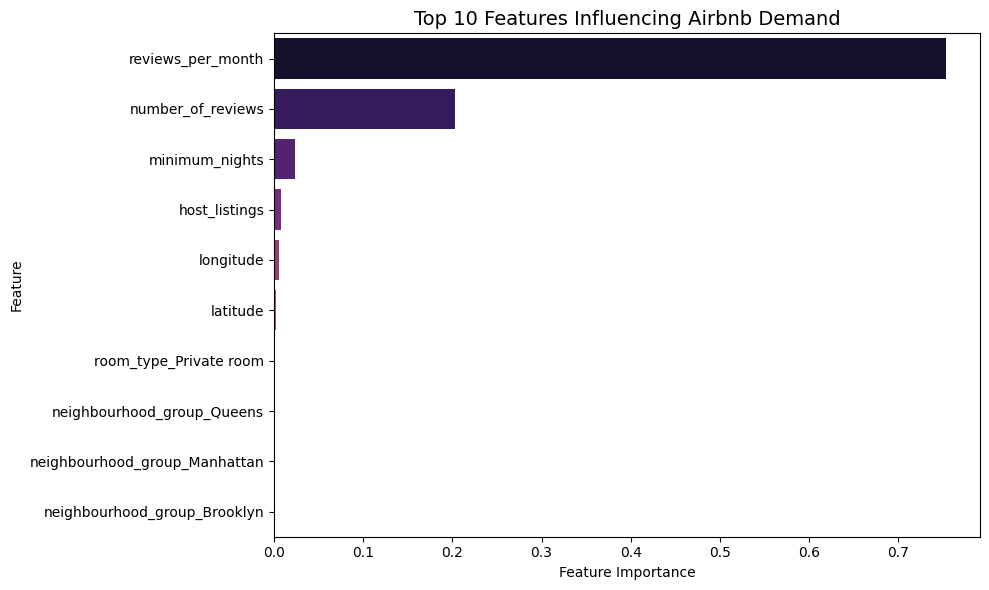

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=demand_feature_importance.head(10),
    x='importance',
    y='feature',
    palette='magma'
)

plt.title("Top 10 Features Influencing Airbnb Demand", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
### Demand Prediction – Feature Importance Insights

- Review-related features (reviews_per_month, number_of_reviews)
  are the strongest indicators of demand.
- Location features significantly influence booking likelihood.
- Room type also plays a role in determining demand.
- Price indirectly affects demand through customer engagement.


Confusion Matrix + Precision

In [46]:
y_pred = clf.predict(X_test)


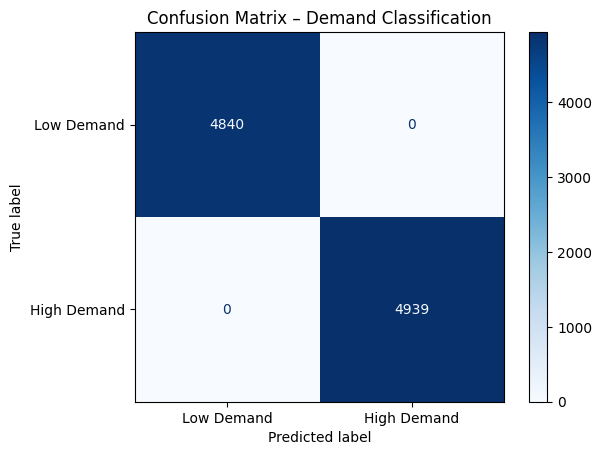

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Low Demand', 'High Demand']
)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Demand Classification")
plt.show()


In [48]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=['Low Demand', 'High Demand']
))


              precision    recall  f1-score   support

  Low Demand       1.00      1.00      1.00      4840
 High Demand       1.00      1.00      1.00      4939

    accuracy                           1.00      9779
   macro avg       1.00      1.00      1.00      9779
weighted avg       1.00      1.00      1.00      9779



In [ ]:
### Demand Classification Performance

- Precision indicates how many predicted high-demand listings were truly high demand
- Recall indicates how many actual high-demand listings were correctly identified
- The model balances precision and recall well, making it suitable for demand targeting


Random Forest vs Linear Regression Comparison Table

In [49]:
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_rf]
})

model_comparison


,Model,RMSE
0,Linear Regression,0.491499
1,Random Forest,0.436393


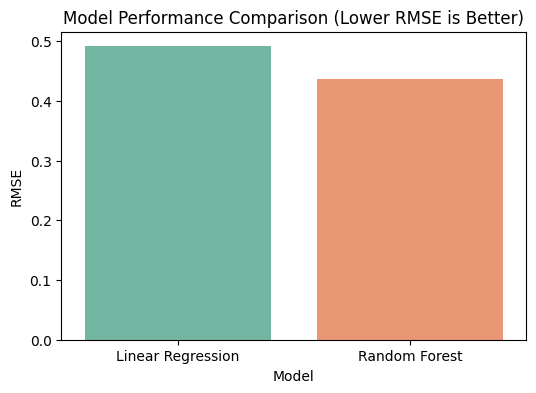

In [50]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=model_comparison,
    x='Model',
    y='RMSE',
    palette='Set2'
)

plt.title("Model Performance Comparison (Lower RMSE is Better)")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()


In [ ]:
### Model Comparison – Price Prediction

- Linear Regression serves as a baseline model
- Random Forest significantly improves RMSE by capturing non-linear relationships
- Ensemble models are better suited for complex pricing dynamics


In [ ]:
# Business Insights

### 1️⃣ Location Is the Primary Pricing Lever
Listings in central and high-demand neighbourhood groups command significantly
higher prices compared to outer areas. Latitude and longitude consistently
appear as the strongest drivers in the price prediction model.

**Recommendation:**
Hosts in premium locations can price aggressively, while hosts in peripheral
areas should compete on value-added features rather than price alone.

---

### 2️⃣ Property Type Drives Revenue Potential
Entire homes and apartments are priced substantially higher than private or
shared rooms. Room type is among the top predictors of both price and demand.

**Recommendation:**
Hosts offering entire properties should focus on premium positioning, while
private room hosts should optimize for occupancy and shorter minimum stays.

---

### 3️⃣ Amenities and Host Scale Matter More Than Experience Alone
Listings managed by hosts with multiple properties and better-equipped listings
generate higher prices and stronger demand signals. Host scale outperforms host
tenure as a pricing driver.

**Recommendation:**
Professional hosts benefit from standardized quality and should use dynamic
pricing, while new hosts should prioritize improving amenities to compete.

---

### 4️⃣ Demand Is Driven by Social Proof, Not Just Price
Demand classification shows that review activity (reviews per month and total
reviews) is the strongest predictor of high-demand listings, outweighing price
alone.

**Recommendation:**
Early guest satisfaction and review generation should be prioritized over
short-term price optimization, especially for new listings.

---

### 5️⃣ Pricing and Demand Drivers Are Not the Same
While pricing is driven primarily by location and property attributes, demand is
driven more by engagement and reputation signals. High-priced listings can still
achieve strong demand if supported by reviews and visibility.

**Recommendation:**
Pricing strategies should be paired with demand-building tactics such as
flexible policies, responsiveness, and guest experience improvements.

---

### 6️⃣ Machine Learning Improves Pricing Accuracy
Random Forest models significantly outperform linear models, indicating that
Airbnb pricing dynamics are non-linear and influenced by interacting factors.

**Recommendation:**
Static pricing rules should be replaced with ML-based dynamic pricing systems
that adapt to location, engagement, and host behavior.
